In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

In [ ]:
CSV_URL = "https://drive.google.com/uc?export=download&id=1rzMmzMRXGi15vu37GmPErK4k8scOiQ9G"

## 0. Introduction
### We will be creating an algorithm to make some money trading on a specific stock. I'll spoil the underlying way that this stock's data is being generated. Let $P_t$ be the price of the stock at time $t$. We will define $r_t = P_t - P_{t-1}$, which is not exactly the returns, but instead the difference between price at time $t$ and $t-1$. We have

### $$ r_t = \phi r_{t-1} + \beta_0 z_{0,t} + \beta_1 z_{1,t} + \beta_2 z_{2,t} + \beta_3 z_{3,t} + \varepsilon_t $$

### We have that $z_{0,t}, z_{1,t}, z_{2,t}, z_{3,t}$ are some alternative data that the stock at time $t$. And we have some error, $\varepsilon_t$ at time $t$. We have some coefficients, $\phi, \beta_0, \beta_1, \beta_2, \beta_3$, that we are trying to learn to be able to make future predictions of the stock price and then trade accordingly. Run the below code, and you can see what the training dataset looks like.

In [ ]:
train = pd.read_csv(CSV_URL)
train.head()

,z_0,z_1,z_2,z_3,time_index,price
0,0.640285,-0.226290,-0.155112,0.135767,6,48.752910
1,0.207124,0.156611,0.779002,-0.126418,7,48.088787
2,0.546695,0.304358,-1.121747,-0.915712,8,47.687610
3,0.567360,0.484419,1.082405,-2.234972,9,47.527526
4,0.613726,-2.412482,-0.056192,-2.480624,10,47.682464


In [ ]:
columns = ['z_0', 'z_1', 'z_2', 'z_3', 'price']
train = train[columns]

train.head()

,z_0,z_1,z_2,z_3,price
0,0.640285,-0.226290,-0.155112,0.135767,48.752910
1,0.207124,0.156611,0.779002,-0.126418,48.088787
2,0.546695,0.304358,-1.121747,-0.915712,47.687610
3,0.567360,0.484419,1.082405,-2.234972,47.527526
4,0.613726,-2.412482,-0.056192,-2.480624,47.682464


Text(0.5, 1.0, 'Stock Price Over Time')

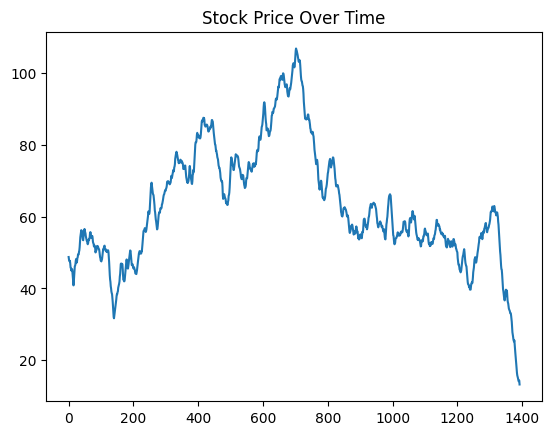

In [ ]:
plt.plot(train['price'])
plt.title('Stock Price Over Time')

## 1. Data Preprocessing

### We need to preprocess the data into chunks such that our model can easily use it. Specifically, we are going to transform the prince into change in price, and transform the factors into $X$ such that we detrend the model. Thus, we will work to do this. We will first compute the difference.

In [ ]:
# this defines a new column that will just be X_t - X_{t-1}
train['price_diff'] = train['price'].diff()

# we note that the first value is NaN since there is no previous value to subtract from
# thus for simplicity, we will set it to be 0
train['price_diff'].iloc[0] = 0

In [ ]:
# look at which columns we should be extracting:
train.head()

,z_0,z_1,z_2,z_3,price,price_diff
0,0.640285,-0.226290,-0.155112,0.135767,48.752910,0.000000
1,0.207124,0.156611,0.779002,-0.126418,48.088787,-0.664123
2,0.546695,0.304358,-1.121747,-0.915712,47.687610,-0.401177
3,0.567360,0.484419,1.082405,-2.234972,47.527526,-0.160084
4,0.613726,-2.412482,-0.056192,-2.480624,47.682464,0.154939


In [ ]:
# extract our X model matrix
columns = ["z_0", "z_1", "z_2", "z_3"]

X = train[columns].values

## 2. De-linearizing

### Now we will try and estimate how much of the factors contribute into the change in price at every time point. To do this we will fit the following model of the returns, and the idea is that we are *detrending* the data. To figure out how much impact the factors affect the price of the stock. Specifically, we will run a linear regression treating the factors as the predictors and the price difference as the response.

### $$ r_t \sim \beta_0 z_{0,t} + \beta_1 z_{1,t} + \beta_2 z_{2,t} + \beta_3 z_{3,t} + \epsilon_t $$

### Note that there is not an autoregressive term, $\phi r_{t-1}$.

#### sklearn is a Python package that has implement a lot of tools that we learned in lecture. We can use `model = LinearRegression()` which is an object that you can `model.fit(X,y)` and then extract out the coefficients using `beta = model.coef_`. Finally print out the beta coefficient `print(beta)`.

In [ ]:
from sklearn.linear_model import LinearRegression

# now we compute the detrended factors
y = train['price_diff'].values

# fit the linear regression
model = LinearRegression()
model.fit(X, y)

# get the beta coefficients
beta = model.coef_
print (beta)

[-0.4419639  -0.00121709 -0.10663716 -0.22375009]


### Now that we have the $\beta$ vector, we will now try and fit for the autoregressive component, $\phi r_{t-1}$. Now to do this we want to *remove* the influence from the factors, $z_t$. To do this we will look at the *residualized* price differences, $\tilde r_t$. This is defined as $\hat r_t = \left(\beta_0 z_{0,t} + \beta_1 z_{1,t} + \beta_2 z_{2,t} + \beta_3 z_{3,t} \right)$

### $$ \tilde r_t = r_t - \hat r_t$$

### We will use these to fit and find the autoregressive coefficient. You can use `hat_r_t = model.predict(X)`. To compute the right hand part of the expression, $\hat r_t$. Now with the rest, we can compute `train['residualized_return'] = train['price_diff'] - hat_r_t`.

In [ ]:
## compute residualized returns
hat_r_t = model.predict(X)

## add train['residualized_return'] column
train['residualized_return'] = train['price_diff'] - hat_r_t
train.head()

,z_0,z_1,z_2,z_3,price,price_diff,residualized_return
0,0.640285,-0.226290,-0.155112,0.135767,48.752910,0.000000,0.313814
1,0.207124,0.156611,0.779002,-0.126418,48.088787,-0.664123,-0.500337
2,0.546695,0.304358,-1.121747,-0.915712,47.687610,-0.401177,-0.466429
3,0.567360,0.484419,1.082405,-2.234972,47.527526,-0.160084,-0.276123
4,0.613726,-2.412482,-0.056192,-2.480624,47.682464,0.154939,-0.120516


## 3. Autoregression

### Now will try the autoregressive component. To do this we will be running a linear regression, by regressing the previous, $r_{t-1}$ to the current $\tilde r_t$ since we are trying to figure out how much impact is being made by the residual component.

### $$\tilde r_t \sim \phi r_{t-1}$$

### If you don't understand why we are doing this. Ask ChatGPT to explain this to you, and it will make a lot more sense. Below just fit `ar_model.fit(lagged_X, residual_y)`, and then let `phi = ar_model.coef_[0]` and print out the value of $\phi$ `print(phi)`.

In [ ]:
## Regress the residualized returns against the lagged returns

# extract lagged returns
train['lagged_return'] = train['residualized_return'].shift(1)
train['lagged_return'].iloc[0] = 0  # set first value to

lagged_X = train['lagged_return'].values.reshape(-1, 1)
residual_y = train['residualized_return'].values

# fit the linear regression
ar_model = LinearRegression()
ar_model.fit(lagged_X, residual_y)

# get the autoregressive coefficient
phi = ar_model.coef_[0]
print(phi)

0.7004411107295498


### Now we have this `model_price` function that basically takes int everything you need and will output the predicted price at time $t$.

In [ ]:
## create model
def model_price(z_t, r_t_minus_1, price_t_minus_1, beta, phi):
    predicted_return = np.dot(beta, z_t) + phi * r_t_minus_1
    price_t = price_t_minus_1 + predicted_return
    return price_t

### The code below will take in your model that is a function of $\beta$ and $\phi$ that was computed from the analysis above. Now we can look at the performance. As we learned in lecture, your P&L (profits and losses) is the total amount of money that you have made minue the money that you have lost after using the strategy.

### The strategy below is basically buying 5 shares of the stock if the predicted change is price is positive, and will sell if the predicted price is negative. We can see the P&L of your stragey as time goes on. We should see your cumulative P&L going straight up that shows over time.

Total realized P&L (price-diff units): 2414.478249


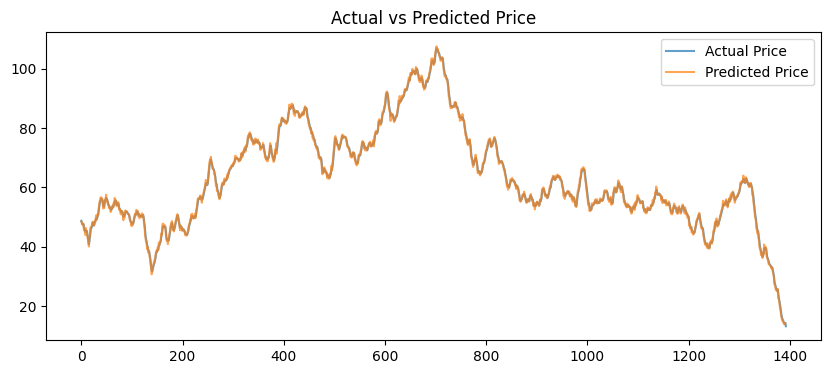

In [ ]:
predicted_prices = []
predicted_returns = []
positions = []
realized_returns = []

shares = 5

n = len(train)
if 'residualized_return' not in train.columns:
    raise KeyError("Column 'residualized_return' not found. Run the residualization cells first.")
lagged_resid = train['residualized_return'].shift(1).fillna(0).values

for i in range(n - 1):
    z_t = train[['z_0', 'z_1', 'z_2', 'z_3']].iloc[i].values
    pred_ret = np.dot(beta, z_t) + phi * lagged_resid[i]
    pred_price = train['price'].iloc[i] + pred_ret

    predicted_returns.append(pred_ret)
    predicted_prices.append(pred_price)

    pos = 1 if pred_ret > 0 else -1
    positions.append(pos)

    realized = 5 * pos * (train['price'].iloc[i + 1] - train['price'].iloc[i])
    realized_returns.append(realized)

predicted_prices.append(np.nan)
predicted_returns.append(np.nan)
positions.append(0)
realized_returns.append(0.0)

train['predicted_price'] = predicted_prices
train['predicted_return'] = predicted_returns
train['position'] = positions
train['realized_pnl'] = realized_returns
train['cumulative_pnl'] = np.cumsum(train['realized_pnl'])

total_return = train['cumulative_pnl'].iloc[-1]
print(f"Total realized P&L (price-diff units): {total_return:.6f}")

display_cols = ['price', 'predicted_price', 'predicted_return', 'position', 'realized_pnl', 'cumulative_pnl']

plt.figure(figsize=(10,4))
plt.plot(train['price'].values, label='Actual Price', alpha = 0.7)
plt.plot(train['predicted_price'].values, label='Predicted Price', alpha = 0.7)
plt.title('Actual vs Predicted Price')
plt.legend()
plt.show()


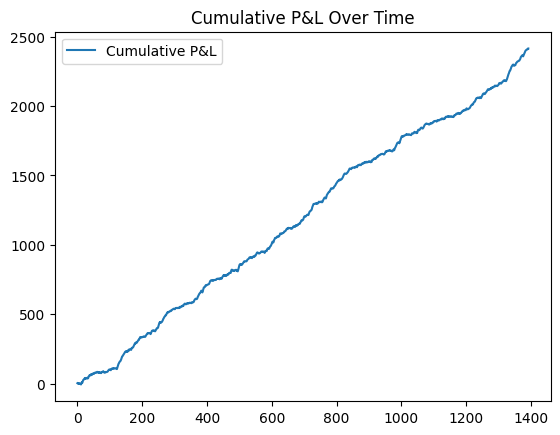

In [ ]:
plt.plot(train['cumulative_pnl'].values, label='Cumulative P&L')
plt.title('Cumulative P&L Over Time')
plt.legend()

In [ ]:
train[display_cols].tail(12)

,price,predicted_price,predicted_return,position,realized_pnl,cumulative_pnl
1381,19.901808,19.095524,-0.806283,-1,5.966704,2385.238098
1382,18.708467,17.802179,-0.906288,-1,6.510715,2391.748813
1383,17.406324,16.417619,-0.988705,-1,4.863692,2396.612506
1384,16.433585,15.791486,-0.642099,-1,3.465566,2400.078071
1385,15.740472,15.102224,-0.638249,-1,1.668306,2401.746377
1386,15.406811,15.090692,-0.316119,-1,1.918236,2403.664613
1387,15.023164,14.535291,-0.487873,-1,2.330420,2405.995033
1388,14.557080,14.215531,-0.341549,-1,2.103278,2408.098311
1389,14.136424,13.861523,-0.274901,-1,-0.105758,2407.992552
1390,14.157576,14.263659,0.106083,1,0.885575,2408.878127


### Write down three different things that could have been done differently. Also, try and list some (1 or 2) errors in the analysis above.
#### *Hint: We have a training set, but what are we missing?*

### Changes or Additions:
+ 1.
+ 2.
+ 3.
### Errors or Mistakes:
+ 1.
+ 2. (Optional)
